# Imports/Setup

In [25]:
from sympy.physics.mechanics import dynamicsymbols, vlatex
from sympy.physics import units
from sympy.physics.units.systems import SI
import sympy.physics.vector as vec
import sympy as sp
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from IPython.display import display, SVG
vec.init_vprinting()

# Parameters

## Symbols

In [26]:
# Radius of Lever Arm
r_m = sp.Symbol('r_m')
# Length of Push Rod
l_r = sp.Symbol('l_r')
# Radius of Ball
r_B = sp.Symbol('r_B')
# Vertical Distance from U-Joint to CG of Platform
r_G = sp.Symbol('r_G')
# Horizontal Distance from U-Joint to Push-Rod Pivot
l_P = sp.Symbol('l_P')
# Vertical Distance from U-Joint to Push-Rod Pivot
r_P = sp.Symbol('r_P')
# Vertical Distance from U-Joint to Platform Surface
r_C = sp.Symbol('r_C')
# Mass of Ball
m_B = sp.Symbol('m_B')
# Mass of Platform
m_P = sp.Symbol('m_P')
# Moment of Inertia of Platform (About Horizontal Axis through CG)
I_P = sp.Symbol('I_P')
# Viscous Friction at U-Joint
b = sp.Symbol('b')

# Gravity
g = sp.Symbol('g')
# Moment of inertia of ball about its center
I_B = sp.Symbol('I_B')

### Use sympy quantities?

In [27]:
# quant = {}
# def quantity(name, dim, u, value):
#     Q = units.Quantity(name, name)
#     SI.set_quantity_dimension(Q, dim)
#     SI.set_quantity_scale_factor(Q, value * u)
#     quant[name] = Q

# param_mm = {'r_m': 60,
#             'l_r': 50,
#             'r_B': 10.5,
#             'r_G': 42,
#             'l_P': 110,
#             'r_P': 32.5,
#             'r_C': 50}

# for name, value in param_mm.items():
#     quantity(name, units.length, units.mm, value)
# quantity('m_B', units.mass, units.gram, 30)
# quantity('m_P', units.mass, units.gram, 400)
# quantity('I_P', units.mass * units.length ** 2,
#     units.gram * units.mm ** 2, 1880000)
# quantity('b', units.length * units.force * units.time,
#     units.N * units.mm * units.s / units.rad, 10)
# quantity('g', units.acceleration, units.m * units.s ** 2, 9.81)

# sym = {}
# for name in param_mm:
#     sym[name] = sp.Symbol(name)
# sym['m_B'] = sp.Symbol('m_B')
# sym['m_P'] = sp.Symbol('m_P')
# sym['I_P'] = sp.Symbol('I_P')
# sym['b'] = sp.Symbol('b')
# sym['g'] = sp.Symbol('g')

# sym_to_quant = {}
# for name in quant:
#     sym_to_quant[sym[name]] = quant[name]

### Numbers in SI units

In [28]:
param_mm = {'r_m': 60,
            'l_r': 50,
            'r_B': 10.5,
            'r_G': 42,
            'l_P': 110,
            'r_P': 32.5,
            'r_C': 50}

sym = {}
sym_to_num = {}
for name in param_mm:
    sym[name] = sp.Symbol(name)
    sym_to_num[sym[name]] = param_mm[name] / 1000 # convert to m
sym['m_B'] = sp.Symbol('m_B')
sym['m_P'] = sp.Symbol('m_P')
sym['I_P'] = sp.Symbol('I_P')
sym['b'] = sp.Symbol('b')
sym['g'] = sp.Symbol('g')
    
sym_to_num['m_B'] = 0.030       # kg
sym_to_num['m_P'] = 0.400       # kg
sym_to_num['I_P'] = 1.88e-3     # kg-m^2
sym_to_num['b'] = 10 / 1000     # N-m-s/rad
sym_to_num['g'] = 9.81          # m/s^2

## Motion Variables

The required variables for the problem are set up as sympy `Symbol`s. The
ball position, $x$, and platform angle, $\theta_y$, are set up as
`dynamicsymbols` since this will allow them to be printed using the dot
notation for derivatives. The derivatives of $x$ and $\theta_y$ are given
names for convenience.

In [29]:
# Time
t = sp.Symbol('t')
# Platform angle and derivatives
thy = dynamicsymbols('theta_y')
thyd = sp.diff(thy, t)
thydd = sp.diff(thy, t, 2)
# Ball position and derivatives
x = dynamicsymbols('x')
xd = sp.diff(x, t)
xdd = sp.diff(x, t, 2)

# Motor Arm Angle
phi_x = sp.Symbol('phi_x')
# Motor torque
T_x = sp.Symbol('T_x')
# Effective moment on platform
M_y = sp.Symbol('M_y')

# Acceleration of ball
a_B = sp.Symbol('a_B')
# Acceleration of platform center of mass
a_G = sp.Symbol('a_G')
# Angular acceleration of ball
alpha_B = sp.Symbol('alpha_B')
# Angular acceleration of platform
alpha_P = sp.Symbol('alpha_P')


# Kinematics

## Linkage
The platform is linked to the motor by the motor arm AD and pushrod PQ.

Assumptions:
1.  The pushrod remains vertical.
2.  The mechanism remains close to the pictured reference position. This
    means we can use the small angle approximation everywhere.

By assumption 1, the vertical displacement from the reference position is
equal at points P and Q. If we express this displacement at each point, we can
set these expressions equal to find the kinematics of the linkage:
$$r_m\sin{\phi_x} = -l_P\sin{\theta_y}$$
For a small angle:
$$r_m\phi_x = -l_P\theta_y$$
$$\theta_y = -\frac{r_m}{l_P}\phi_x$$
We can take derivatives with respect to time to get the angular velocity and
angular accleration relationships as the same ratio:
$$\dot{\theta_y} = -\frac{r_m}{l_P}\dot{\phi_x}$$
$$\ddot{\theta_y} = -\frac{r_m}{l_P}\ddot{\phi_x}$$

## Ball and Plate


Using Sympy's vector math capabilities, we can set up a global (inertial) 
reference frame, N.
Next, make a rotating reference frame aligned with N on their y-axes
and attached to the platform, P.
Then we define the platform pivot point O and fix it in the global frame.
This point is also the origin for both N and P. Refer to the diagram below.

In [30]:
# Global reference frame (inertial)
N = vec.ReferenceFrame('N')
# Reference frame attached to platform (rotating)
P = N.orientnew('P', 'Axis', [thy, N.y])
# Origin point, not moving
O = vec.Point('O')
O.set_vel(N, 0)

Next, define point B, the center of mass of the ball, and point G, the center
of mass of the platform, in the platform frame P. Use these equations for the
displacement vectors of points B and G from O:
$$\mathbf{\vec{r}}_{B/O} = x\hat{x}_P + (r_B + r_B) \hat{z}_P$$
$$\mathbf{\vec{r}}_{G/O} = r_G \hat{z}_P

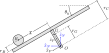

In [31]:
display(SVG(filename='./kinematics.svg', ))

In [32]:
r_BO = x * P.x + (r_C + r_B) * P.z
B = O.locatenew('B', r_BO)
B.set_vel(P, r_BO.dt(P))
r_GO = r_G * P.z
G = O.locatenew('G', r_GO)

Use Sympy's `a1pt_theory` and `a2pt_theory` kinematics methods to find the
accelerations of the ball and platform at their centers of mass in the global
frame N. These implement the 5-term acceleration equation to translate the
acceleration in the rotating reference frame to the global frame.

In [33]:
a_B = B.a1pt_theory(O, N, P)
a_G = G.a2pt_theory(O, N, P)

Since the ball rolls without slip, its angular acceleration is:
$$\alpha_B = \ddot{\theta_y} + \frac{\ddot{x}}{r_B}$$
The platform's angular acceleration is:
$$\alpha_P = \ddot{\theta_y}$$
Define these angular accelerations in Python:

In [34]:
alpha_B = (thydd + xdd/r_B) * P.y
alpha_P = thydd * P.y

# Kinetics

## Linkage

Using the method of virtual work, we can find the relationship between the
motor torque and the effective moment on the platform. 
Assumptions:
1.  The motor and pushrod have negligible inertia and mass. 
2.  There is no friction or other loss of energy

By these assumptions, no energy can be stored, and all the work done by the
motor will go to the platform.
$$dE = dW_{IN} - dW_{OUT} = 0$$
$$dW_{IN} = dW_{OUT}$$
On both sides of the linkage, the work is done by a torque over a small 
anglular displacement.
$$T_x d\phi_x = M_y d\theta_y$$
$$M_y = T_X \frac{d\phi_x}{d\phi_y}$$
We can substitute for the time derivative of the angle.
$$M_y = T_X \frac{\frac{d\phi_x}{dt}}{\frac{d\phi_y}{dt}}$$
$$M_y = T_x \frac{\dot{\phi_x}}{\dot{\theta_y}}$$
We can substitute the kinematic relationship between the angular velocity that
we found earlier.
$$M_y = -\frac{l_P}{r_m} T_x$$


In [35]:
M_y = -l_P/r_m * T_x * P.y

## Ball and Platform

Express the weights of the ball and platform as vectors in the global frame.

In [36]:
weight_ball = m_B * g * -N.z
weight_platform = m_P * g * -N.z

Note that the moment of inertia of the ball about
its center of mass, $I_B$, is
$$I_B=\frac{2}{5}m_Br_B^2$$
and the moment on the plate due to damping in the U-joint is:
$$M_{damper} = -b \dot{\theta}_y$$

In [37]:
I_B = 2/5 * m_B * r_B ** 2
M_damper = -b * thyd * P.y

Considering the system of the ball and plate, we sum moments about the pivot
point of the platform, O. See the free-body diagram and moment equation below.

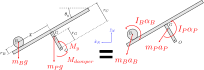

In [38]:
display(SVG(filename='./FBDKDplate.svg'))

$$
\Sigma M_O \mathrm{:}
M_y \hat{y}_N +
M_{damper} +
\vec{\mathbf{r}}_{B/O} \times (-m_B g \hat{z}_N) +
\vec{\mathbf{r}}_{G/O} \times (-m_P g \hat{z}_N) =
I_B \vec{\alpha}_B +
I_P \vec{\alpha}_P +
\vec{\mathbf{r}}_{B/O} \times m_B \vec{\mathbf{a}}_B +
\vec{\mathbf{r}}_{G/O} \times m_P \vec{\mathbf{a}}_P
$$

This equation can be evaluated in sympy, to get a differential equation in
terms of $x$, $\theta_y$, and the system parameters.

In [39]:
FBD_both = vec.cross(r_BO, weight_ball) + vec.cross(r_GO, weight_platform) \
    + M_y + M_damper
KD_both = vec.cross(r_BO, m_B * a_B) + vec.cross(r_GO, m_P * a_G) \
    + I_P * alpha_P + I_B * alpha_B

These expressions are still in vector form, but only have a y-component. To
set them equal easily, take the dot product of them with the unit vector in
the y-direction. Also expand the terms of the equation.

In [40]:
FBD_both = FBD_both.dot(N.y).expand()
KD_both = KD_both.dot(N.y).expand()

Also apply the small angle approximation $\sin{\theta_y} \approx \theta_y$,
$\cos{\theta_y} \approx 1$. Now the equation for the kinetics of the ball
can be displayed.

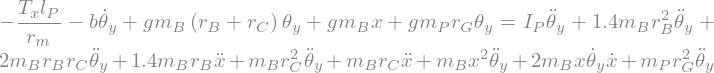

In [41]:
FBD_both = FBD_both.subs({sp.sin(thy): thy, sp.cos(thy): 1})
sp.Eq(FBD_both.collect([m_B * g * thy]), KD_both)

Next, Consider the ball alone. Sum moments about the contact point of the ball 
on the surface of the platform, C.

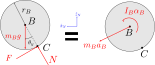

In [42]:
display(SVG(filename='./FBDKDball.svg'))

$$
\Sigma M_C\colon
\vec{\mathbf{r}}_{B/C} \times (-m_B g \hat{z}_N) =
I_B \vec{\alpha}_B +
\vec{\mathbf{r}}_{B/C} \times m_B \vec{\mathbf{a}}_B
$$

Evaluate this equation in sympy and perform the same simplifications as above.

In [43]:
FBD_ball = vec.cross(r_B * P.z, weight_ball)
KD_ball = vec.cross(r_B * P.z, m_B * a_B) + I_B * alpha_B
KD_ball = KD_ball.dot(P.y).expand()
FBD_ball = FBD_ball.dot(P.y).subs(sp.sin(thy), thy)
sp.Eq(FBD_ball, KD_ball)

In matrix form, these two equations are:
$$M \ddot{\mathbf{q}} = \mathbf{f}$$
$$
\left[\begin{matrix}- \frac{I_{B}}{r_{B}} - m_{B} r_{B} - m_{B} r_{C} & - I_{B} - I_{P} - m_{B} r_{B}^{2} - 2 m_{B} r_{B} r_{C} - m_{B} r_{C}^{2} - m_{B} x^{2} - m_{P} r_{G}^{2}\\- \frac{I_{B}}{r_{B}} - m_{B} r_{B} & - I_{B} - m_{B} r_{B}^{2} - m_{B} r_{B} r_{C}\end{matrix}\right]
\left[\begin{matrix}\ddot{x}\\\ddot{\theta}_{y}\end{matrix}\right]      =
\left[\begin{matrix}\frac{T_{x} l_{P}}{r_{m}} + b \dot{\theta}_{y} - g m_{B} r_{B} \theta_{y} - g m_{B} r_{C} \theta_{y} - g m_{B} x - g m_{P} r_{G} \theta_{y} + 2 m_{B} x \dot{\theta}_{y} \dot{x}\\- g m_{B} r_{B} \theta_{y} - m_{B} r_{B} x \dot{\theta}_{y}^{2}\end{matrix}\right]
$$


Next, convert these equations of motion into a state space form, so the system
can be simulated. The desired form is
$\dot{\mathbf{x}} = A \mathbf{x} + B \mathbf{u}$ where
$\mathbf{x} = \left[\begin{matrix}x\\\theta_y\\\dot{x}\\\dot{\theta}_{y}\end{matrix}\right]$ and
$\dot{\mathbf{x}} = \left[\begin{matrix}\dot{x}\\\dot{\theta}_{y}\\\ddot{x}\\\ddot{\theta}_{y}\end{matrix}\right]$

First, collect the elements of the left matrix $\mathbf{M}$
and the right vector $\mathbf{f}$ from above.

In [44]:
M11 = -KD_both.coeff(xdd)
M12 = -KD_both.coeff(thydd)
M21 = -KD_ball.coeff(xdd)
M22 = -KD_ball.coeff(thydd)
f1 = -FBD_both + (KD_both + M11 * xdd + M12 * thydd).simplify()
f2 = -FBD_ball + (KD_ball + M21 * xdd + M22 * thydd).simplify()

Assemble these elements into sympy matrices, and calculate the unknown vector 
$\ddot{\mathbf{q}}$.
$$\ddot{\mathbf{q}} = M^{-1} \mathbf{f}$$

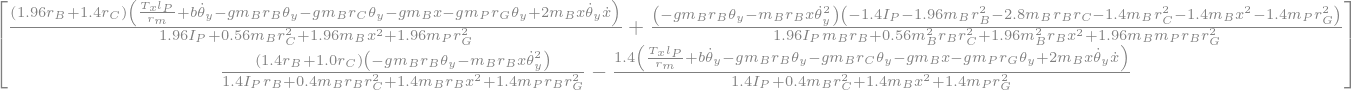

In [45]:
M = sp.Matrix([[M11, M12], [M21, M22]])
f = sp.Matrix([f1, f2])
qdd = M ** -1 * f
qdd

Set up the state vector and its derivative using the $\ddot{\mathbf{q}}$
vector just found.
$$\mathbf{x} = \left[ \begin{matrix} \mathbf{q} \\ \dot{\mathbf{q}} \end{matrix} \right], \quad
\dot{\mathbf{x}} = \left[ \begin{matrix} \dot{\mathbf{q}} \\ \ddot{\mathbf{q}} \end{matrix} \right]$$

In [49]:
state = sp.Matrix([x, thy, xd, thyd])
stated = sp.Matrix([sp.Matrix([xd, thyd]), qdd])

The equation for q contains nonlinear terms such as
$2 m_B x \dot{\theta_y} \dot{x}$ and
$-m_B r_B x \dot{\theta_y}^2$.
To represent the system in state-space, it must be linearized. This is done by
a Jacobian linearization. First, find the Jacobian matrix of the derivative of
the state vector $\dot{\mathbf{x}}$, with respect to the state vector
$\mathbf{x}$.
$$\mathbf{J}_\mathbf{x} = \frac{\partial \dot{\mathbf{x}}(\mathbf{x},\mathbf{u})}{\partial \mathbf{x}}$$

In [ ]:
J_x = stated.jacobian(state)

Also find the Jacobian matrix of $\dot{\mathbf{x}}$ with respect to the input
$\mathbf{u} = T_x$. 
$$\mathbf{J}_\mathbf{u} = \frac{\partial \dot{\mathbf{x}}(\mathbf{x},\mathbf{u})}{\partial \mathbf{u}}

In [ ]:
J_u = stated.jacobian([T_x])


The operating point about which we will linearize is
the state where the ball is at rest in the center of a level plate, and there 
is no torque input from the motor ($\mathbf{x}=0, \mathbf{u}=T_x=0$).
This is a steady state, and the system will not be able
to deviate too far from it while the ball moves on its area.

In [ ]:
operating_point = {x: 0, thy: 0, xd: 0, thyd: 0, T_x: 0}


$A$ is $\mathbf{J_x}$ evaluated at this operating point:
$$ A = \mathbf{J_x}|_{\mathbf{x}=0,\mathbf{u}=0}$$

In [ ]:
A = J_x.subs(operating_point)
A

And $B$ is $\mathbf{J_u}$ evaluated at the same operating point:
$$ B = \mathbf{J_u}|_{\mathbf{x}=0,\mathbf{u}=0}$$

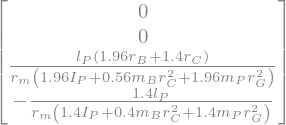

In [ ]:
B = J_u.subs(operating_point)
B

This completes the state-space model. Now, to simulate it numerically, the
parameters given will be substituted and the matrix will be converted to a
numpy array. The parameter values are in SI units (MKS) so
no conversion factors are necessary.

In [ ]:
A_num = np.array(A.subs(sym_to_num).tolist(), dtype=np.float64)
B_num = np.array(B.subs(sym_to_num).tolist(), dtype=np.float64)

Define a function that calculates the derivative of the state given the
state and input. This uses matrix multiplication from numpy.

In [ ]:
def calc_state_d(current_state, torque):
    return A_num @ current_state + B_num @ torque

For open loop, the torque input is always 0.

In [ ]:
def open_loop(t, current_state):
    return calc_state_d(current_state, np.array([0]))

The controller for the system will use full state feedback, 
$\mathbf{u} = T_x = - K \mathbf{x}$. 

The gains are shown in the matrix form of this
equation,
$$
T_x = - \left[ \begin{matrix} -0.3 & -0.2 & -0.05 & -0.02 \end{matrix} \right]
\left[ \begin{matrix} x \\ \theta_y \\ \dot{x} \\ \dot{\theta_y} \end{matrix} \right]
$$
These gains are for a nearly fuel-optimal controller.

In [ ]:
def closed_loop(t, current_state):
    K = np.array([[-0.3, -0.2, -0.05, -0.02]])
    torque = -K @ current_state
    return calc_state_d(current_state, torque)

There are two initial conditions we wish to consider.
1.  The ball is at rest in the center of the platform (directly above the
    U-joint) and the platform is level and at rest.
2.  The ball is at rest 5cm away from the center of the platform, which is
    level and at rest.

Form the state vectors for these initial conditions.

In [ ]:
ball_at_rest = np.array([0, 0, 0, 0])
ball_offset = np.array([0.05, 0, 0, 0])

Define a function to plot all of the state variables from the results of the
simulation in a window with 4 subplots.

In [ ]:
def plot_state(result, title):
    plt.figure(figsize=(10, 6))
    plt.suptitle(title)
    ylabels = [r"Ball Position, $x$ [m]", r"Platform angle $\theta_y$ [rad]",
        r"Ball Velocity [m/s]", r"Platform Angular Velocity, [rad/s]"]
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(result.t, result.y[i, :])
        plt.xlabel("Time, t [s]")
        plt.ylabel(ylabels[i])
    plt.tight_layout()

Now the simulation can be done by solving the state space equation. First,
run it in open loop with the ball in the first initial condition.

In [ ]:
OL_center = integrate.solve_ivp(open_loop, [0, 1], ball_at_rest)
plot_state(OL_center, "Open Loop Response for Ball Started at Rest, in Center "
    "of Level Platform at Rest")

As expected, the ball and platform will stay still according to the model.
Next, run the open-loop simulation with the ball starting from the condition
with the ball offset.

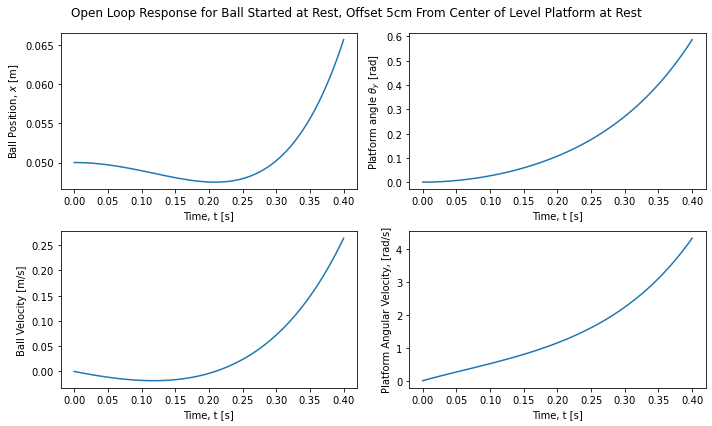

In [ ]:
OL_off = integrate.solve_ivp(open_loop, [0, 0.4], ball_offset, 
    t_eval=np.linspace(0, 0.4, 1000))
plot_state(OL_off, "Open Loop Response for Ball Started at Rest, Offset 5cm "
    "From Center of Level Platform at Rest")

This result is expected as well, the platform tilts down on the side the ball
is started on and the ball rolls further down the plate. One thing that I did
not expect to see was the ball's position going closer to the center of the
plate, before it began to roll away from the center. I think that this must
be due to the platform rotating into the ball, which makes the ball get closer
to the center of the plate due to the height of the platform $r_C$.

The next simulation to run is the one that will start with the ball in the
same offset position, but in closed loop with the motor attempting to balance
the ball.

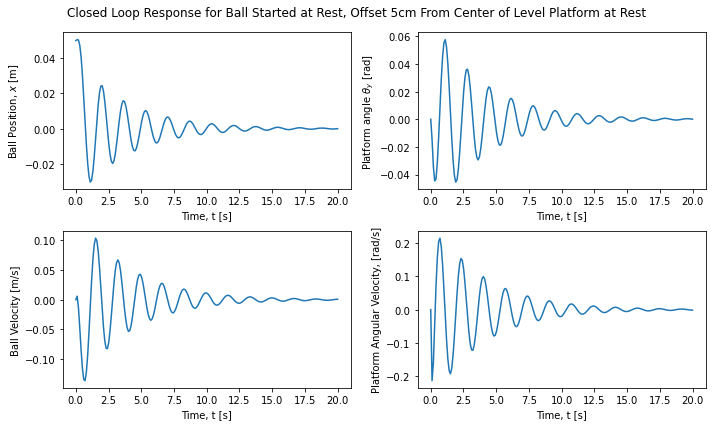

In [ ]:
CL_offset = integrate.solve_ivp(closed_loop, [0, 20], ball_offset, t_eval=np.linspace(0, 20, 1000))
plot_state(CL_offset, "Closed Loop Response for Ball Started at Rest, Offset "
    "5cm From Center of Level Platform at Rest")

These results are expected. There is oscillation in the position and velocity
of the ball and the platform which decays slowly to 0. The phase of the plaform
position is opposite of the ball position because it is attempting to balance
the ball.

# Utilities

This prints some $\LaTeX$ that can be used to show the equations of motion in
matrix form.

In [ ]:
print('$$')
print(vlatex(M))
print(vlatex(qdd))
print('=')
print(vlatex(f))
print('$$')

$$
\left[\begin{matrix}- 1.4 m_{B} r_{B} - m_{B} r_{C} & - I_{P} - 1.4 m_{B} r_{B}^{2} - 2 m_{B} r_{B} r_{C} - m_{B} r_{C}^{2} - m_{B} x^{2} - m_{P} r_{G}^{2}\\- 1.4 m_{B} r_{B} & - 1.4 m_{B} r_{B}^{2} - m_{B} r_{B} r_{C}\end{matrix}\right]
\left[\begin{matrix}\frac{\left(1.96 r_{B} + 1.4 r_{C}\right) \left(\frac{T_{x} l_{P}}{r_{m}} + b \dot{\theta}_{y} - g m_{B} \left(\left(r_{B} + r_{C}\right) \theta_{y} + x\right) - g m_{P} r_{G} \theta_{y} + 2 m_{B} x \dot{\theta}_{y} \dot{x}\right)}{1.96 I_{P} + 0.56 m_{B} r_{C}^{2} + 1.96 m_{B} x^{2} + 1.96 m_{P} r_{G}^{2}} + \frac{\left(- g m_{B} r_{B} \theta_{y} - m_{B} r_{B} x \dot{\theta}_{y}^{2}\right) \left(- 1.4 I_{P} - 1.96 m_{B} r_{B}^{2} - 2.8 m_{B} r_{B} r_{C} - 1.4 m_{B} r_{C}^{2} - 1.4 m_{B} x^{2} - 1.4 m_{P} r_{G}^{2}\right)}{1.96 I_{P} m_{B} r_{B} + 0.56 m_{B}^{2} r_{B} r_{C}^{2} + 1.96 m_{B}^{2} r_{B} x^{2} + 1.96 m_{B} m_{P} r_{B} r_{G}^{2}}\\\frac{\left(1.4 r_{B} + 1.0 r_{C}\right) \left(- g m_{B} r_{B} \theta_{y} - m_{B} r_{B} 

In [ ]:
print('$$')
print(vlatex(sp.diff(state)), '=')
print(vlatex(A))
print(vlatex(state), '+')
print(vlatex(B))
print(vlatex(T_x))
print('$$')

$$
\left[\begin{matrix}\dot{x}\\\dot{\theta}_{y}\\\ddot{x}\\\ddot{\theta}_{y}\end{matrix}\right] =
\left[\begin{matrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\- \frac{g m_{B} \left(1.96 r_{B} + 1.4 r_{C}\right)}{1.96 I_{P} + 0.56 m_{B} r_{C}^{2} + 1.96 m_{P} r_{G}^{2}} & - \frac{g m_{B} r_{B} \left(- 1.4 I_{P} - 1.96 m_{B} r_{B}^{2} - 2.8 m_{B} r_{B} r_{C} - 1.4 m_{B} r_{C}^{2} - 1.4 m_{P} r_{G}^{2}\right)}{1.96 I_{P} m_{B} r_{B} + 0.56 m_{B}^{2} r_{B} r_{C}^{2} + 1.96 m_{B} m_{P} r_{B} r_{G}^{2}} + \frac{\left(1.96 r_{B} + 1.4 r_{C}\right) \left(- g m_{B} \left(r_{B} + r_{C}\right) - g m_{P} r_{G}\right)}{1.96 I_{P} + 0.56 m_{B} r_{C}^{2} + 1.96 m_{P} r_{G}^{2}} & 0 & \frac{b \left(1.96 r_{B} + 1.4 r_{C}\right)}{1.96 I_{P} + 0.56 m_{B} r_{C}^{2} + 1.96 m_{P} r_{G}^{2}}\\\frac{1.4 g m_{B}}{1.4 I_{P} + 0.4 m_{B} r_{C}^{2} + 1.4 m_{P} r_{G}^{2}} & - \frac{g m_{B} r_{B} \left(1.4 r_{B} + 1.0 r_{C}\right)}{1.4 I_{P} r_{B} + 0.4 m_{B} r_{B} r_{C}^{2} + 1.4 m_{P} r_{B} r_{G}^{2}} - \frac{1.4 \left(- g

$\left[\begin{matrix}\dot{x}\\\dot{\theta}_{y}\\\ddot{x}\\\ddot{\theta}_{y}\end{matrix}\right] =
\left[\begin{matrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\- \frac{g m_{B} \left(I_{B} r_{B} + m_{B} r_{B}^{3} + m_{B} r_{B}^{2} r_{C}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}} & - \frac{g m_{B} r_{B} \left(- I_{B} r_{B} - I_{P} r_{B} - m_{B} r_{B}^{3} - 2 m_{B} r_{B}^{2} r_{C} - m_{B} r_{B} r_{C}^{2} - m_{P} r_{B} r_{G}^{2}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}} + \frac{\left(I_{B} r_{B} + m_{B} r_{B}^{3} + m_{B} r_{B}^{2} r_{C}\right) \left(- g m_{B} r_{B} - g m_{B} r_{C} - g m_{P} r_{G}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}} & 0 & \frac{b \left(I_{B} r_{B} + m_{B} r_{B}^{3} + m_{B} r_{B}^{2} r_{C}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}}\\- \frac{g m_{B} \left(- I_{B} - m_{B} r_{B}^{2}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}} & - \frac{g m_{B} r_{B} \left(I_{B} + m_{B} r_{B}^{2} + m_{B} r_{B} r_{C}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}} + \frac{\left(- I_{B} - m_{B} r_{B}^{2}\right) \left(- g m_{B} r_{B} - g m_{B} r_{C} - g m_{P} r_{G}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}} & 0 & \frac{b \left(- I_{B} - m_{B} r_{B}^{2}\right)}{I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}}\end{matrix}\right]
\left[\begin{matrix}x\\\theta_{y}\\\dot{x}\\\dot{\theta}_{y}\end{matrix}\right] +
\left[\begin{matrix}0\\0\\\frac{l_{P} \left(I_{B} r_{B} + m_{B} r_{B}^{3} + m_{B} r_{B}^{2} r_{C}\right)}{r_{m} \left(I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{B} x^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B}^{2} r_{B}^{2} x^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}\right)}\\\frac{l_{P} \left(- I_{B} - m_{B} r_{B}^{2}\right)}{r_{m} \left(I_{B} I_{P} + I_{B} m_{B} r_{C}^{2} + I_{B} m_{B} x^{2} + I_{B} m_{P} r_{G}^{2} + I_{P} m_{B} r_{B}^{2} + m_{B}^{2} r_{B}^{2} x^{2} + m_{B} m_{P} r_{B}^{2} r_{G}^{2}\right)}\end{matrix}\right]
T_{x}$